# Predicting Affordability of Twin-Cities Housing Rental Ads

# The Problem


### - rental housing scarcity 

### - unaffordable rental housing


# Craigslist Dataset - obtained through web-scraping listings December 2017 - April 2018


# Density of Listings

In [3]:
import folium
from folium import plugins
import geojson
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
# read in cleaned rentals data as geodataframe
data = pd.read_csv(r"C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Collection and Cleaning\Data Sources\cleaned_data_final.csv")
# convert latitude and longitude points into GIS data points
geometry = [Point(xy) for xy in zip(data['geocode_lon'], data['geocode_lat'])]
# set projections for geometry 
crs = {'init': 'epsg:4326'}
locations = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)
locations = locations.to_crs({'init': 'epsg:4326'})
# create geodataframe of zipcodes of Minnesota
zipcodes = gpd.GeoDataFrame.from_file(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Storytelling\MN_Zipcodes\zip_code_tabulation_areas.shp')
# set projection of zipcodes
zipcodes = zipcodes.to_crs({'init': 'epsg:4326'})
# rename column of minnesota zipcodes file
zipcodes = zipcodes.rename(columns={'GEOID10': 'zipcodes'})
# perform spatial join between craigslist 
loc_zip_join = gpd.sjoin(locations, zipcodes, how="left", op='within')
# re-size dataframe to only include necessary columns
final_df = loc_zip_join[['address', 'beds boolean', 'beds_baths', 'county', 'county_full', 'datetime', 'geocode_lat', 'geocode_lon', 'post id', 'price', 'price boolean', 'square feet', 'square feet boolean', 'title', 'url', 'County', 'City', 'bed assigned', 'no match', 'index match', 'outlier', 'zipcodes']]
df_vals_over_fmr = pd.read_csv(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Collection and Cleaning\over_fmr_dataframe.csv')
beds_per_zip_craigslist = pd.read_csv(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Storytelling\craigslist_munged.csv')
# subset minnesota zipcodes
# so as to match those containing craigslist rental ads
# in ramsey and hennepin county
# merge zipcodes spatial data with munged dataframe
beds_per_zip_craigslist['zipcodes'] = beds_per_zip_craigslist['zipcodes'].astype(int)
zipcodes['zipcodes'] = zipcodes['zipcodes'].astype(int)
choropleth_input = zipcodes.merge(beds_per_zip_craigslist, how = 'left', left_on = "zipcodes", right_on = "zipcodes")
# create json
choropleth_input = choropleth_input.dropna()
choropleth_json = choropleth_input.to_json()
json_map = json.loads(choropleth_json)
# create map
m = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
# convert to (n, 2) nd-array format for heatmap
heat_points = final_df[['geocode_lat', 'geocode_lon']].as_matrix()
# convert heatpoints to list
heat_points = heat_points.tolist()
# plot heatmap
m.add_child(plugins.HeatMap(heat_points, radius=10))
m.save(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Storytelling\vizualizations\craigslist_listings.html')
m

C:\Users\murra667\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Use HUD Twin-Cities Fair Market Rent as a proxy for affordability 

### Twin Cities Fair Market Rents $
     Studio: 711

     1 Bedroom: 864

     2 Bedroom: 1089

     3 Bedroom: 1547

     4 Bedroom: 1812


### Create "Over FMR" Value in Dataset

    - "Over FMR" is a boolean type denoting whether a rent price is above or below affordability threshold 
    
        - (Bedroom type FMR) + (1 Bedroom type standard devation) = affordability threshold
        
        - Studio = 711 + 289 = 1,000
        
        - 1 Bedroom = 864 + 326.8 = 1190.8
        
        - 2 Bedroom = 1089 + 518.7 = 1607.7
        
        - 3 Bedroom = 1547 + 576.6 = 2123.6
        
        - 4 Bedroom = 1812 + 779.7 = 2591.7

# Affordability Difference

##### - (Percentage of craigslist listings in zipcode) - (Percentage of craigslist listings in zipcode one standard deviation over FMR) = Affordability Difference

In [4]:
beds_per_zip_craigslist['zipcodes'] = beds_per_zip_craigslist['zipcodes'].astype(float)
# create map object
fmr_map = folium.Map(location=[44.986656, -93.258133], zoom_start=12)
# create choropleth map
fmr_map.choropleth(geo_data = json_map, data = beds_per_zip_craigslist,
         columns=['zipcodes', 'affordability difference'],
         key_on='feature.properties.zipcodes',
         threshold_scale = [-.05, -.025, -.005, .005, .025, .05],
         legend_name = 'Difference Between Expected Percent of Listings Over FMR and True Percent of Listings Over FMR', fill_opacity=.6, line_opacity=.9,
         fill_color='RdYlBu' )
# save maps
fmr_map.save(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Storytelling\vizualizations\overfmr.html')
#display map
fmr_map

# Selecting Important Attributes For Machine Learning

<module 'matplotlib.pyplot' from 'C:\\Users\\murra667\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

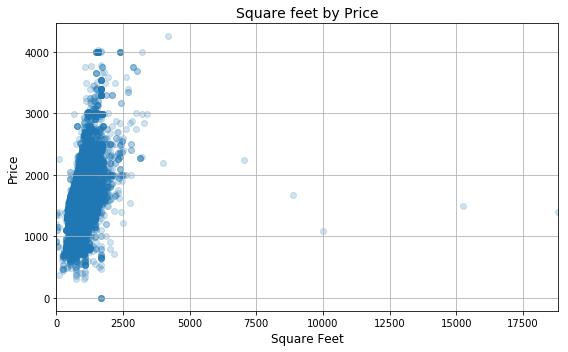

In [13]:
import matplotlib.pyplot as plt
data = pd.read_csv(r"C:\Users\murra667\Documents\Springboard\Capstone _1\Data_Collection\Craigslist Data\geocode_2\Data Collection and Cleaning\Data Sources\cleaned_data_final.csv")
# generate a scatterplot for price vs square feet 
# and create lists as inputs
x = [a for a in data['square feet']]
y = list(data['price'])
# generate plot object
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)
# set plot configurations
ax.set_xlim([0, max(x)])
ax.set_xlabel('Square Feet', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Square feet by Price', fontsize=14)
# set plot layout
ax.grid(True)
fig.tight_layout()
plt

#  Features Used In Machine Learning

baths: contained in at least one of the tags pulled during web scraping

total: Total number of units in zipcode

density:  Population per square miles in zipcode

water area:  Aggregate amount of water area in square meters per zipcode

population: Total population in zipcode

land area: aggregate amount of land area in square meters per zipcode

square feet: the square feet of the listing pulled during web scraping

beds: The beds value contained in at least one of the tags pulled during web scraping

MINNEAPOLIS: A number denoting whether a listing is in Minneapolis as per conclusions made during inferential statistics of a statistically significancant difference in affordability between Minneapolis and St. Paul

    Minneapolis = 1
    
    non-minneapolis = 0

SAINT PAUL: A number denoting whether a listing is in Saint Paul as per conclusions made during inferential statistics of a statistically significancant difference in affordability between Minneapolis and St. Paul
        
    Saint Paul = 1
    
    non- st. paul = 0

main_city: A number denoting whether a listing is in St. Paul or Minneapolis, or a suburban city as per conclusions made during inferential statistics about statistical significant difference of proportion of affordable listings between the suburbs and the two main cities. 

    listing is in Minneapolis or Saint Paul = 1
    
    listing is in a suburb = 0
    

#### *These attributes were chosen using basic knowledge of what tends to impact housing cost and housing affordability in major metropolitan areas and per conclusions of running inferential statistics on the dataset.

# Making Predictions That A Listing Is Over Affordability Threshold

In [15]:
import pickle
with open(r'C:\Users\murra667\Documents\Springboard\Capstone _1\Machine Learning\predictions_table.pickle', 'rb') as f:
    x = pickle.load(f)
x

Models,Model Type,Accuracy,Recall,Features Used
str31,str19,float64,str32,str111
All Features Model,Random Forest,0.9266267619231512,0.918600078647267,"MINNEAPOLIS, SAINT PAUL, main_city, baths, total, density, water area, population, land area, square feet, beds"
Census Data & Square Feet Model,Random Forest,0.9104074145587951,0.9078233927188226,"square feet, population, water area, density, land area"
Craigslist Only Model,Random Forest,0.8914848426337131,0.8829701372074253,"square feet, baths, beds, MINNEAPOLIS, SAINT PAUL, main_city"
Final Model,Random Forest,0.9260474995172814,0.9298952457695407,"square feet, land area, baths, beds"
Logistic Regression,Logistic Regression,0.7248769186214885,N/A,"square feet, baths, beds, MINNEAPOLIS, SAINT PAUL, main_city"
